In [3]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score, confusion_matrix


In [4]:
# Load the data
data = pd.read_csv('merged_solar_weather_data.csv')

# Convert 'DATE_TIME' to datetime format (matching the format: 'YYYY-MM-DD HH:MM:SS')
data['DATE_TIME'] = pd.to_datetime(data['DATE_TIME'], format='%Y-%m-%d %H:%M:%S')

# Drop columns that are not useful (for example, LOCATION, SENSOR_ID, or any other metadata)
data = data.drop(columns=['LOCATION', 'SENSOR_ID'])

# Handle missing values (using forward fill)
data = data.ffill()

# Set 'DATE_TIME' as the index
data.set_index('DATE_TIME', inplace=True)

# Select features (X) and target (Y) - You can use DC_POWER or AC_POWER as the target
features = data[['AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE', 'IRRADIATION', 'DAILY_YIELD', 'TOTAL_YIELD']]
target = data['DC_POWER']  # You can change this to AC_POWER or another target


In [5]:
# Normalize the features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Train-test split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(features_scaled, target, test_size=0.2, shuffle=False)

# Reshape the data for LSTM input (samples, time steps, features)
X_train_reshaped = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test_reshaped = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))


Epoch 1/50
3412/3412 [==============================] - 6s 1ms/step - loss: 12730368.0000 - val_loss: 1146517.2500
Epoch 2/50
3412/3412 [==============================] - 4s 1ms/step - loss: 4451642.0000 - val_loss: 2615493.0000
Epoch 3/50
3412/3412 [==============================] - 4s 1ms/step - loss: 1464321.2500 - val_loss: 2287241.7500
Epoch 4/50
3412/3412 [==============================] - 4s 1ms/step - loss: 1047260.4375 - val_loss: 1871865.7500
Epoch 5/50
3412/3412 [==============================] - 4s 1ms/step - loss: 958156.9375 - val_loss: 1799361.8750
Epoch 6/50
3412/3412 [==============================] - 4s 1ms/step - loss: 915324.6875 - val_loss: 1694344.7500
Epoch 7/50
3412/3412 [==============================] - 4s 1ms/step - loss: 887478.4375 - val_loss: 1551888.2500
Epoch 8/50
3412/3412 [==============================] - 4s 1ms/step - loss: 864477.5625 - val_loss: 1573991.0000
Epoch 9/50
3412/3412 [==============================] - 5s 1ms/step - loss: 845177.4375 - v

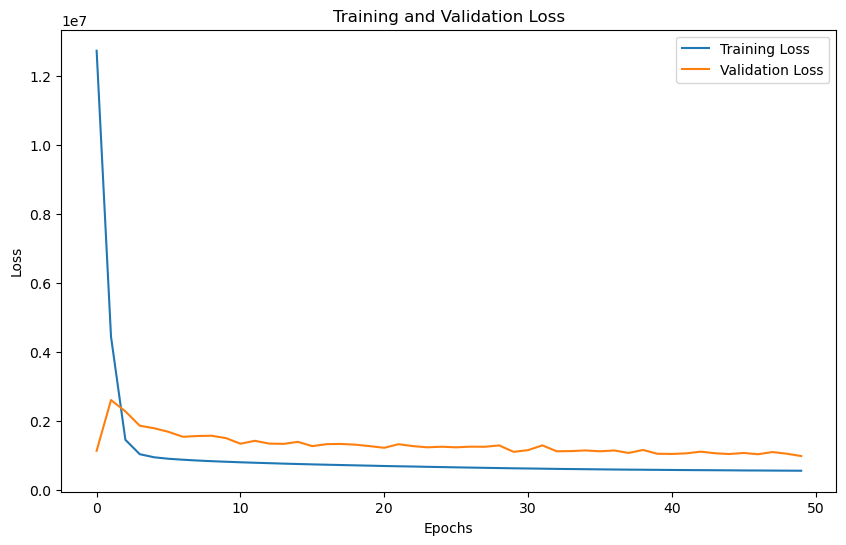

In [6]:
# Build a simple LSTM model
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])))
model.add(Dense(1))  # Predicting a continuous value (DC_POWER)
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train_reshaped, y_train, epochs=50, batch_size=32, validation_data=(X_test_reshaped, y_test))

# Plot training history (optional)
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


853/853 [==============================] - 1s 608us/step


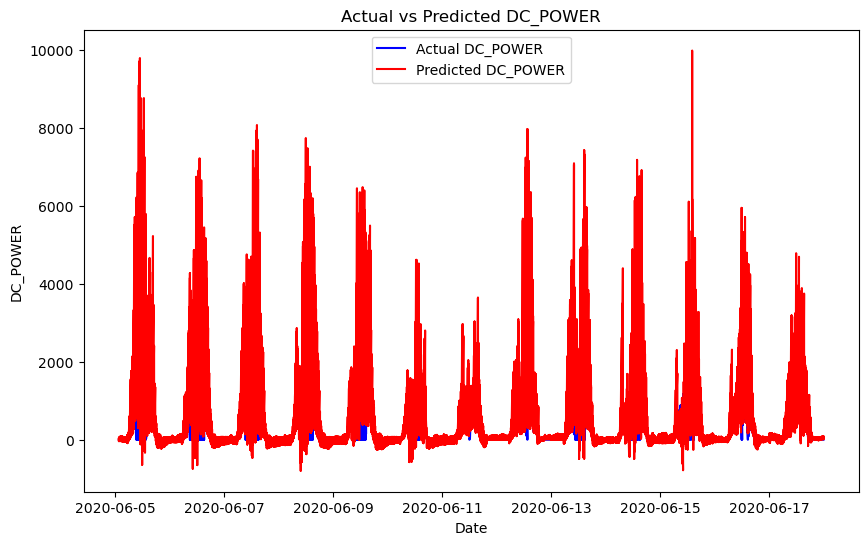

In [7]:
# Predict on the test set
y_pred = model.predict(X_test_reshaped)

# Plot predicted vs actual values
plt.figure(figsize=(10, 6))
plt.plot(y_test.index, y_test.values, label='Actual DC_POWER', color='blue')
plt.plot(y_test.index, y_pred, label='Predicted DC_POWER', color='red')
plt.title('Actual vs Predicted DC_POWER')
plt.xlabel('Date')
plt.ylabel('DC_POWER')
plt.legend()
plt.show()


In [8]:
# Calculate and print the evaluation metrics (MSE, MAE)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")


Mean Squared Error: 994131.8609715529
Mean Absolute Error: 399.35662608708986


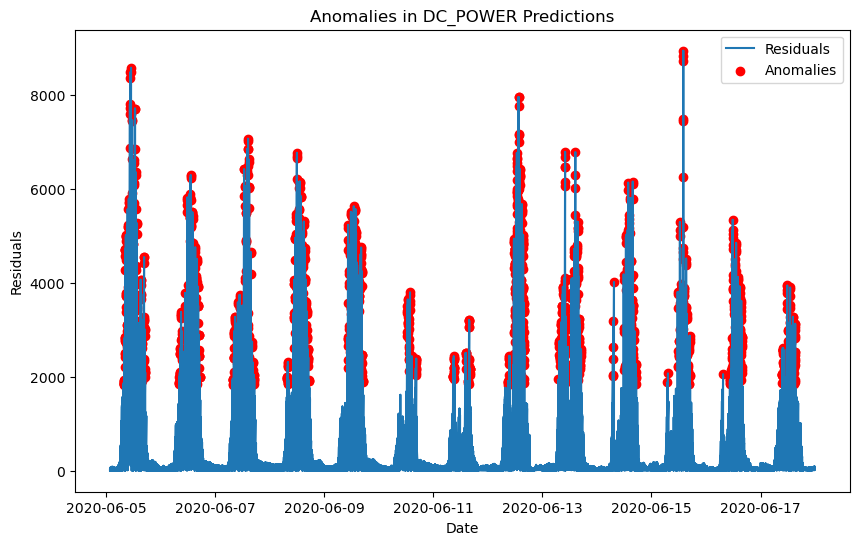

In [9]:
# Flatten y_pred to be 1D
y_pred_flat = y_pred.flatten()

# Calculate residuals (difference between actual and predicted values)
residuals = np.abs(y_test - y_pred_flat)

# Define a threshold for anomaly detection (e.g., 2 standard deviations)
threshold = 2 * np.std(residuals)

# Find anomalies (residuals above the threshold)
anomalies = residuals > threshold

# Plot the anomalies
plt.figure(figsize=(10, 6))
plt.plot(y_test.index, residuals, label='Residuals')
plt.scatter(y_test.index[anomalies], residuals[anomalies], color='red', label='Anomalies')
plt.title('Anomalies in DC_POWER Predictions')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.legend()
plt.show()


In [10]:
# Convert residuals to binary anomaly labels (0 = normal, 1 = anomaly)
anomaly_labels = (residuals > threshold).astype(int)

# Convert predicted residuals to binary predictions
y_pred_binary = (y_pred_flat > threshold).astype(int)

# Calculate accuracy
accuracy = accuracy_score(anomaly_labels, y_pred_binary)
print(f"Accuracy: {accuracy}")

# Confusion matrix
cm = confusion_matrix(anomaly_labels, y_pred_binary)
print(f"Confusion Matrix:\n{cm}")


Accuracy: 0.9825242718446602
Confusion Matrix:
[[25044   477]
 [    0  1774]]
